In [398]:
import pandas as pd
import numpy as np
#
import faiss
import pyterrier as pt
import timeit
import matplotlib.pyplot as plt

In [399]:
if not pt.started():
    pt.init()

In [400]:
# Intersección
def list_intersection(l1, l2):
    s1 = set(l1.tolist()[0])
    s2 = set(l2.tolist()[0])
    s3 = s1.intersection(s2)
    return len(s3) / len(s1), s3

In [401]:
# Calcula similitud por coseno
def cosine_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

---
### MAIN
---

In [402]:
dataset = pt.get_dataset("vaswani")
print("Corpus Vaswani: %s " % dataset.get_corpus())

Corpus Vaswani: ['/home/jovyan/.pyterrier/corpora/vaswani/corpus/doc-text.trec'] 


In [403]:
documents = pd.DataFrame(dataset.get_corpus_iter())
documents.shape

(11429, 2)

In [404]:
documents.head()

,docno,text
0,1,compact memories have flexible capacities a d...
1,2,an electronic analogue computer for solving sy...
2,3,electronic coordinate transformer circuit det...
3,4,the british computer society report of a conf...
4,5,millimicrosecond digital computer logic a sys...


In [405]:
# Calcular embeddings de los documentos
from sentence_transformers import SentenceTransformer, util

In [406]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

In [407]:
doc_text = list(documents['text'].head(10))
doc_embeddings = model.encode(doc_text, convert_to_tensor=True)

In [408]:
print (doc_embeddings.shape)

torch.Size([10, 512])


In [409]:
#doc_embeddings

In [410]:
query_text = ["computer electronic"]
query_embeddings = model.encode(query_text, convert_to_tensor=True)

In [411]:
#query_embeddings

In [412]:
qry = list(query_embeddings[0])

In [413]:

for i, doc in enumerate(doc_embeddings):
    doc = list(doc)
    score = cosine_sim(doc, qry)
    print ("Sim doc: ", i, " query: ", score)

Sim doc:  0  query:  0.06227272
Sim doc:  1  query:  0.36165896
Sim doc:  2  query:  0.25138032
Sim doc:  3  query:  0.22139534
Sim doc:  4  query:  0.13987084
Sim doc:  5  query:  0.09058695
Sim doc:  6  query:  0.21569586
Sim doc:  7  query:  -0.014941954
Sim doc:  8  query:  -0.0014529648
Sim doc:  9  query:  0.12308566


In [414]:
query_text

['computer electronic']

In [415]:
# Cargo los embeddings de todos los docs previamente calculados.
vaswani_docs_embeddings = np.load("../data/vaswani_docs_embeddings-512.npy")
vaswani_docs_embeddings.shape

(11429, 512)

In [104]:
# Obtengo los 'topics' asociados al corpus
topics = dataset.get_topics()
topics.head()

query-text.trec: 10.7kiB [00:00, 24.0MiB/s]                                                                          


,qid,query
0,1,measurement of dielectric constant of liquids ...
1,2,mathematical analysis and design details of wa...
2,3,use of digital computers in the design of band...
3,4,systems of data coding for information transfer
4,5,use of programs in engineering testing of comp...


In [105]:
# Cargo los embeddings de todos los queries previamente calculados.
vaswani_query_embeddings = np.load("../data/vaswani_query_embeddings-512.npy")
vaswani_query_embeddings.shape

(93, 512)

### Indexación con FAISS (diferentes índices)
**Más sobre los tipos de índices en FAISS:** https://github.com/facebookresearch/faiss/wiki/Faiss-indexes

**Prueba 1 - Flat Index**  
Recordar: En este tipo de índice se mide la distancia L2 (euclídea) entre el vector de query 
y todos los vectores de documentos almacenados. Es simple y preciso (pero no demasiado rápido).

In [107]:
# Inicialización
d = 512
indexFlat = faiss.IndexFlatL2(d)

# Chequeo cantidad de docs en el índice
indexFlat.ntotal

0

In [108]:
# Agrego los documentos al índice
%time
indexFlat.add(vaswani_docs_embeddings)
indexFlat.ntotal

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


11429

In [109]:
indexFlat.is_trained

True

In [196]:
# Ejemplo de recuperación
k = 10
query_vector = np.array([vaswani_query_embeddings[0]])

In [197]:
%time
DFlat, rsFlat = indexFlat.search(query_vector, k)  # Búsqueda

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


In [198]:
print(rsFlat)

[[1501 7125 1087 1896 1987 4816 7024 8275 4255 4870]]


In [199]:
DFlat

array([[0.49462646, 0.76442146, 0.8314605 , 0.8432368 , 0.8441225 ,
        0.84579706, 0.8518748 , 0.8526005 , 0.87107503, 0.8739554 ]],
      dtype=float32)

In [200]:
faiss.write_index(indexFlat, "vaswani_faiss_flat.ndx")

**Prueba 2 - IVF Flat Index**  
Recordar: En este tipo de índice se particiona el espacio de búsqueda (nlist) para realizar
un ANN.

In [201]:
nlist = 50  # Cantidad de celdas
base_index  = faiss.IndexFlatL2(d)
indexIVFFlat = faiss.IndexIVFFlat(base_index, d, nlist)

In [202]:
indexIVFFlat.is_trained

False

In [203]:
# Preparo (train) las estructuras de datos del índice
%time
indexIVFFlat.train(vaswani_docs_embeddings)
indexIVFFlat.ntotal

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


0

In [204]:
indexIVFFlat.is_trained

True

In [205]:
# Agrego los documentos al índice
indexIVFFlat.add(vaswani_docs_embeddings)
indexIVFFlat.ntotal

11429

In [224]:
faiss.write_index(indexIVFFlat, "vaswani_faiss_ivfflat.ndx")

In [206]:
# Ejemplo de recuperación
k = 10
indexIVFFlat.nprobe = 1 # Ámbito de búsqueda = 1 celda
query_vector = np.array([vaswani_query_embeddings[0]])

In [207]:
%time
DIVFFlat, rsIVFFlat = indexIVFFlat.search(query_vector, k)  # Búsqueda

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


In [209]:
rsIVFFlat

array([[8275, 4255, 8581, 8481,   57, 3097, 5144, 3435, 8573, 1519]])

In [220]:
list_intersection(rsFlat, rsIVFFlat)

(0.2, {4255, 8275})

In [225]:
# Aumentamos el ámbito de búsqueda a 10 celdas
indexIVFFlat.nprobe = 10
DIVFFlat, rsIVFFlat = indexIVFFlat.search(query_vector, k)  # Búsqueda

In [227]:
list_intersection(rsFlat, rsIVFFlat)

(0.9, {1501, 1896, 1987, 4255, 4816, 4870, 7024, 7125, 8275})

In [ ]:
# Comparación Flat vs IVFlat para todos los queries

In [245]:
query_vectors = np.array(vaswani_query_embeddings)  # Todos los queries
query_vectors.shape

(93, 512)

In [391]:
k = 10
#
t0 = timeit.default_timer()
DFlat, rsFlat = indexFlat.search(query_vectors, k)          # Búsqueda en índice flat (exhaustivo)
t1 = timeit.default_timer()
#
tiempo_exhaustivo = t1-t0
print(f"Elapsed time (exhaustivo): {tiempo_exhaustivo} ms")

Elapsed time (exhaustivo): 0.05777614699945843 ms


In [392]:
indexIVFFlat.nprobe = 10
t0 = timeit.default_timer()
DIVFFlat, rsIVFFlat = indexIVFFlat.search(query_vectors, k)  # Búsqueda en índice flat (particionado)
t1 = timeit.default_timer()
#
tiempo_nprobe10 = t1-t0
print(f"Elapsed time (nprobe=10): {tiempo_nprobe10} ms")

Elapsed time (nprobe=10): 0.027390180999645963 ms


In [417]:
# Tradeoff tiempo/overlap entre índice flat exhaustivo y particionado
search_times    = [tiempo_exhaustivo]
search_overlaps = [1]
labels = ["Exhaustivo"]
#
for nprobe in [1, 10, 20, 30, 40, 50]:
    indexIVFFlat.nprobe = nprobe
    t0 = timeit.default_timer()
    DIVFFlat, rsIVFFlat = indexIVFFlat.search(query_vectors, k)  # Búsqueda en índice flat (particionado)
    t1 = timeit.default_timer()
    # Agrego el tiempo y una etiqueta (nprobe)
    search_times.append(t1-t0)
    labels.append(str(nprobe))
    #
    # Calculo overlap promedio para todas las consultas
    tmp_overlaps = []   
    for i, x in enumerate(rsFlat):
        rs_i1 = set(rsFlat[i])
        rs_i2 = set(rsIVFFlat[i])
        tmp_overlaps.append(len(rs_i1.intersection(rs_i2))/len(rs_i1))
    search_overlaps.append(np.mean(tmp_overlaps))

In [418]:
#search_times

In [419]:
#search_overlaps

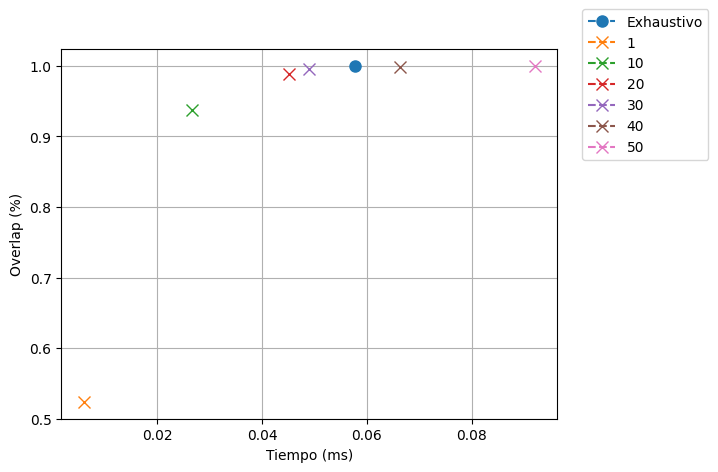

In [420]:
import matplotlib.pyplot as plt
markers = ['o--', 'x--', 'x--','x--','x--', 'x--', 'x--']
for i, codec in enumerate(search_overlaps):
    plt.plot(search_times[i], search_overlaps[i], markers[i], markersize=8, label=labels[i])
#
plt.grid()
plt.xlabel("Tiempo (ms)")
plt.ylabel("Overlap (%)")
#
plt.legend(loc=(1.05, 0.7))
plt.show()

In [ ]:
# De acá para abajo pasa a la notebook de Esteban

Prueba 3 - IVF Flat Index con Product Quantization
Recordar: En este tipo de índice se aplica Product Quantization para reducir (comprimir) los vectores. Luego se ejecuta ANN.

In [ ]:
m = 8  # number of centroid IDs in final compressed vectors
bits = 8 # number of bits in each centroid

quantizer = faiss.IndexFlatL2(d)  # we keep the same L2 distance flat index
indexIVFPQ = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits) 

In [33]:
indexIVFPQ.is_trained

False

In [34]:
# Preparo (train) las estructuras de datos del índice
%time
indexIVFPQ.train(vaswani_docs_embeddings)
indexIVFPQ.ntotal

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


0

In [35]:
# Agrego los documentos al índice
indexIVFPQ.add(vaswani_docs_embeddings)
indexIVFPQ.ntotal

11429

In [36]:
# Ejemplo de recuperación
k = 5
query_vector = np.array([vaswani_query_embeddings[0]])

In [37]:
%time
DIVFPQ, rsIVFPQ = indexIVFPQ.search(query_vector, k)  # Búsqueda

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


In [38]:
rsIVFPQ

array([[1519, 8275, 3326, 4255, 8481]])

In [39]:
indexIVFPQ.nprobe = 10
%time
DIVFPQ, rsIVFPQ = indexIVFPQ.search(query_vector, k)  # Búsqueda

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


In [40]:
rsIVFPQ

array([[1501, 7125, 4249, 1519, 9829]])

In [41]:
faiss.write_index(indexIVFPQ, "vaswani_faiss_ivfpq.ndx")

### Tarea 
**Ejecutar todo el set de consultas y calcular el solapamiento promedio de las listas de 
resultados para nprobe = [1 .. 10]**